<a href="https://colab.research.google.com/github/Prajay404/QCNNFORQSO/blob/main/Redshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 85.0 MB/s eta 0:00:00


Epoch [10/50], Train Loss: 0.4491, Test Loss: 0.5850
Epoch [20/50], Train Loss: 0.4437, Test Loss: 0.5792
Epoch [30/50], Train Loss: 0.4425, Test Loss: 0.5783
Epoch [40/50], Train Loss: 0.4420, Test Loss: 0.5781
Epoch [50/50], Train Loss: 0.4418, Test Loss: 0.5781
Final Test MSE: 0.5781, R2 Score: 0.0986


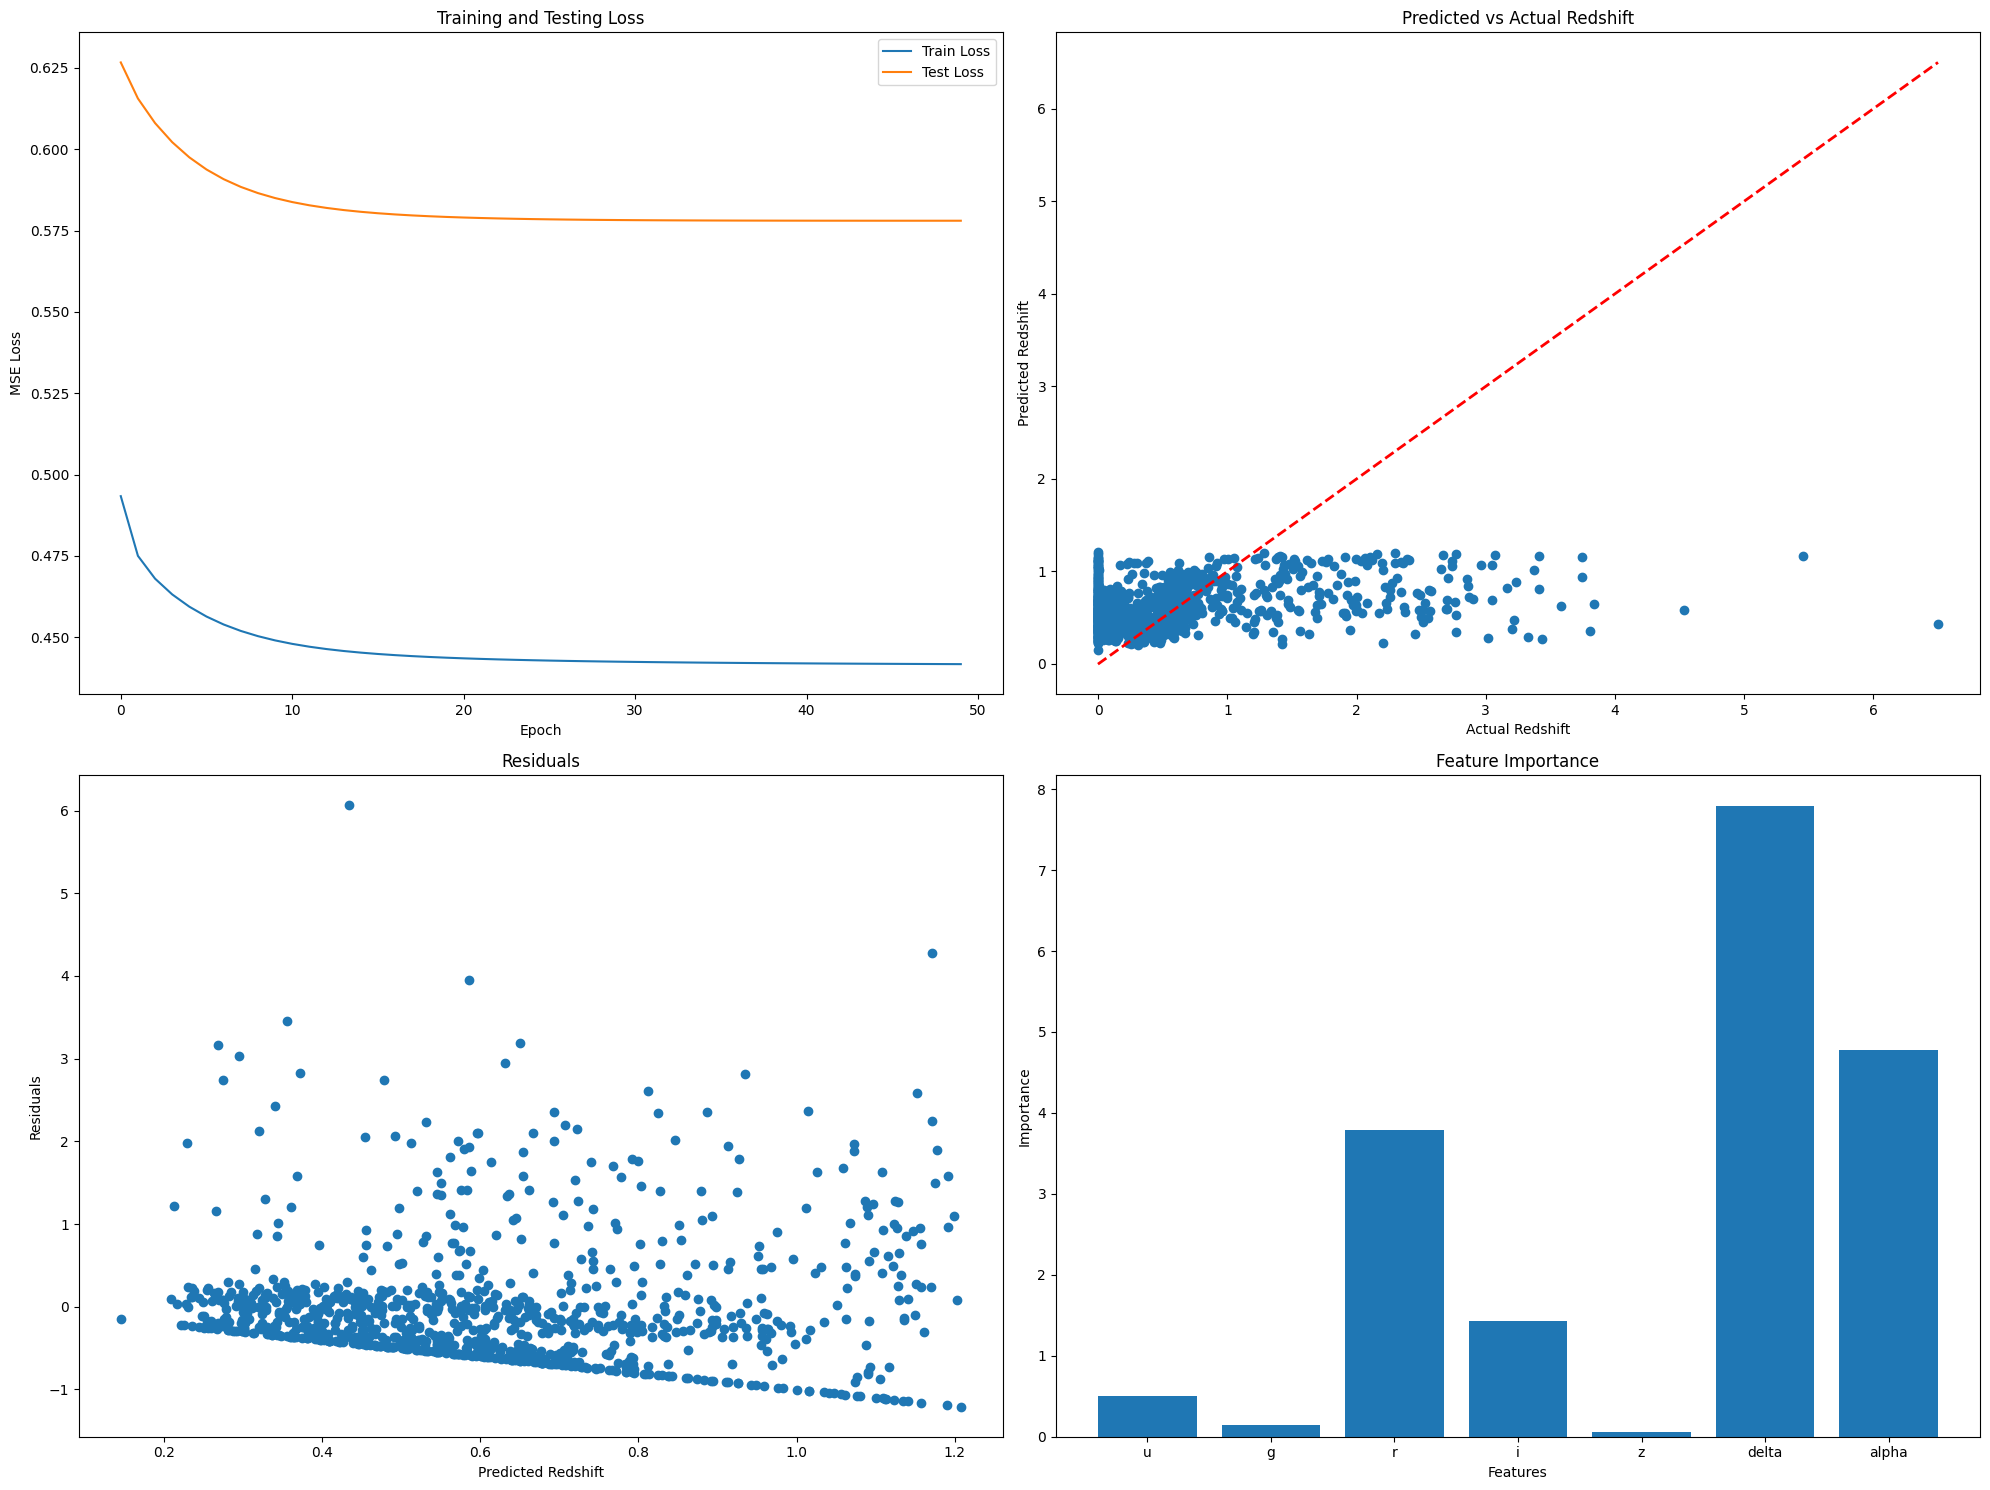

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and preprocess the data
df = pd.read_csv('/content/star_classification.csv')
X = df[['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']]  # Using only the magnitude features
y = df['redshift']

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:2000]
y_train = y[:2000]
X_test = X_scaled[2000:3000]
y_test = y[2000:3000]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define the quantum device
n_qubits = 7  # One qubit for each magnitude feature
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc = nn.Linear(n_qubits, 1)  # Changed to output a single value for redshift

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        return self.fc(x).squeeze()  # Squeeze to remove extra dimension

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Changed to MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 50
batch_size = 32

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / (len(X_train) // batch_size)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()

    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    mse = mean_squared_error(y_test, test_outputs)
    r2 = r2_score(y_test, test_outputs)
    print(f'Final Test MSE: {mse:.4f}, R2 Score: {r2:.4f}')

# Visualizations
plt.figure(figsize=(20, 15))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, test_outputs.detach().numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')

# Residuals
plt.subplot(2, 2, 3)
residuals = y_test - test_outputs.detach().numpy()
plt.scatter(test_outputs.detach().numpy(), residuals)
plt.title('Residuals')
plt.xlabel('Predicted Redshift')
plt.ylabel('Residuals')



# Feature Importance
plt.subplot(2, 2, 4)
feature_importance = np.abs(model.fc.weight.detach().numpy()).squeeze()
features = ['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']
plt.bar(features, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.6104, Val Loss: 0.2969
Epoch [20/50], Train Loss: 0.6017, Val Loss: 0.3103
Epoch [30/50], Train Loss: 0.5809, Val Loss: 0.3058
Epoch [40/50], Train Loss: 0.6212, Val Loss: 0.3019
Epoch [50/50], Train Loss: 0.5785, Val Loss: 0.3006
Mean Squared Error: 0.3006
Mean Absolute Error: 0.4407
R2 Score: -0.0335


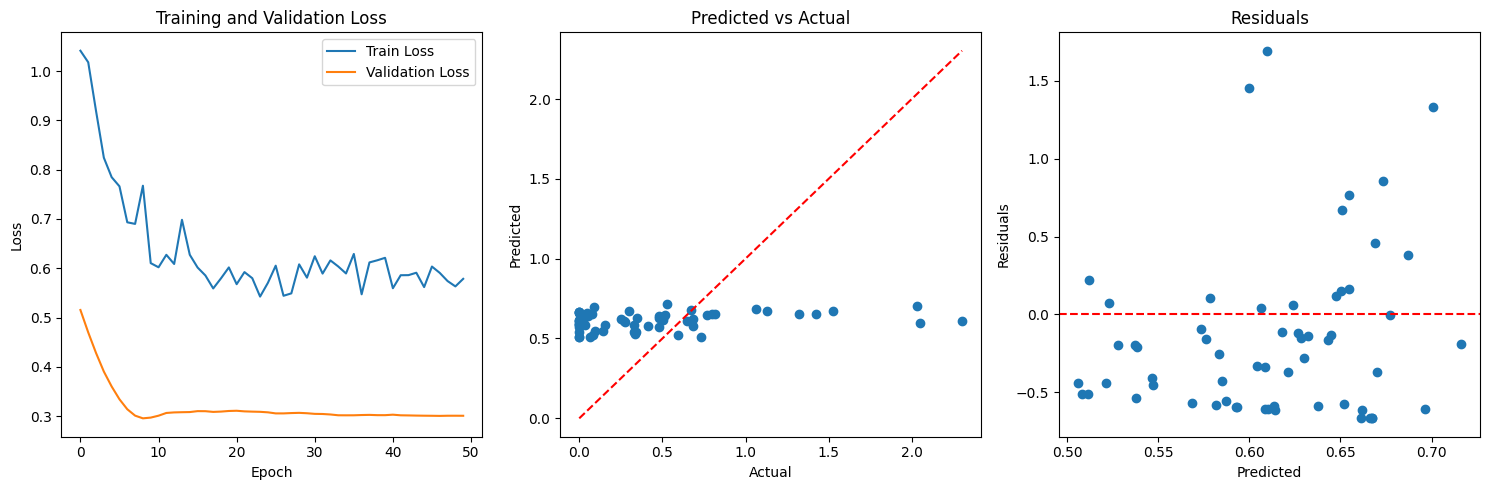

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('/content/star_classification.csv')
X = df[['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']][:300]  # Use only first 300 samples
y = df['redshift'][:300]
features = ['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']
n_qubits = len(features)
dev = qml.device("default.qubit", wires=n_qubits)

# Normalize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:200]
y_train = y[:200]
X_test = X_scaled[200:300]
y_test = y[200:300]


# Split the data with a larger training set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define an enhanced quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights1, weights2):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights1, wires=range(n_qubits))
    qml.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights2, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define an enhanced QCNN model with L2 regularization
class EnhancedQCNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers1 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.q_layers2 = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.fc1 = nn.Linear(n_qubits, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers1, self.q_layers2) for x_i in x], dtype=torch.float32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# Initialize the model
model = EnhancedQCNN(n_qubits=n_qubits, n_layers=2)

# Define loss function and optimizer with L2 regularization
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

# Training loop
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    scheduler.step(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.scatter(y_test.numpy(), y_pred.numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(133)
residuals = y_test.numpy() - y_pred.numpy()
plt.scatter(y_pred.numpy(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [ ]:
# Split the data
X_train = X_scaled[:200]
y_train = y[:200]
X_test = X_scaled[2000:2200]
y_test = y[2000:2200] # Corrected the slice to match X_test

In [ ]:
# ... (previous code) ...

# Define the quantum device
features = ['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']  # Define features here
n_qubits = len(features)
dev = qml.device("default.qubit", wires=n_qubits)

# ... (rest of the code) ...

In [ ]:
%pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 40.8 MB/s eta 0:00:00


Epoch [10/100], Train Loss: 0.4374, Test Loss: 0.7767
Epoch [20/100], Train Loss: 0.4371, Test Loss: 0.7748
Epoch [30/100], Train Loss: 0.4364, Test Loss: 0.7747
Epoch [40/100], Train Loss: 0.4371, Test Loss: 0.7745
Epoch [50/100], Train Loss: 0.4373, Test Loss: 0.7744
Epoch [60/100], Train Loss: 0.4342, Test Loss: 0.7743
Epoch [70/100], Train Loss: 0.4338, Test Loss: 0.7742
Epoch [80/100], Train Loss: 0.4355, Test Loss: 0.7742
Epoch [90/100], Train Loss: 0.4351, Test Loss: 0.7742
Epoch [100/100], Train Loss: 0.4359, Test Loss: 0.7742
Final Test MSE: 0.7742, R2 Score: -0.0094


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (10,).

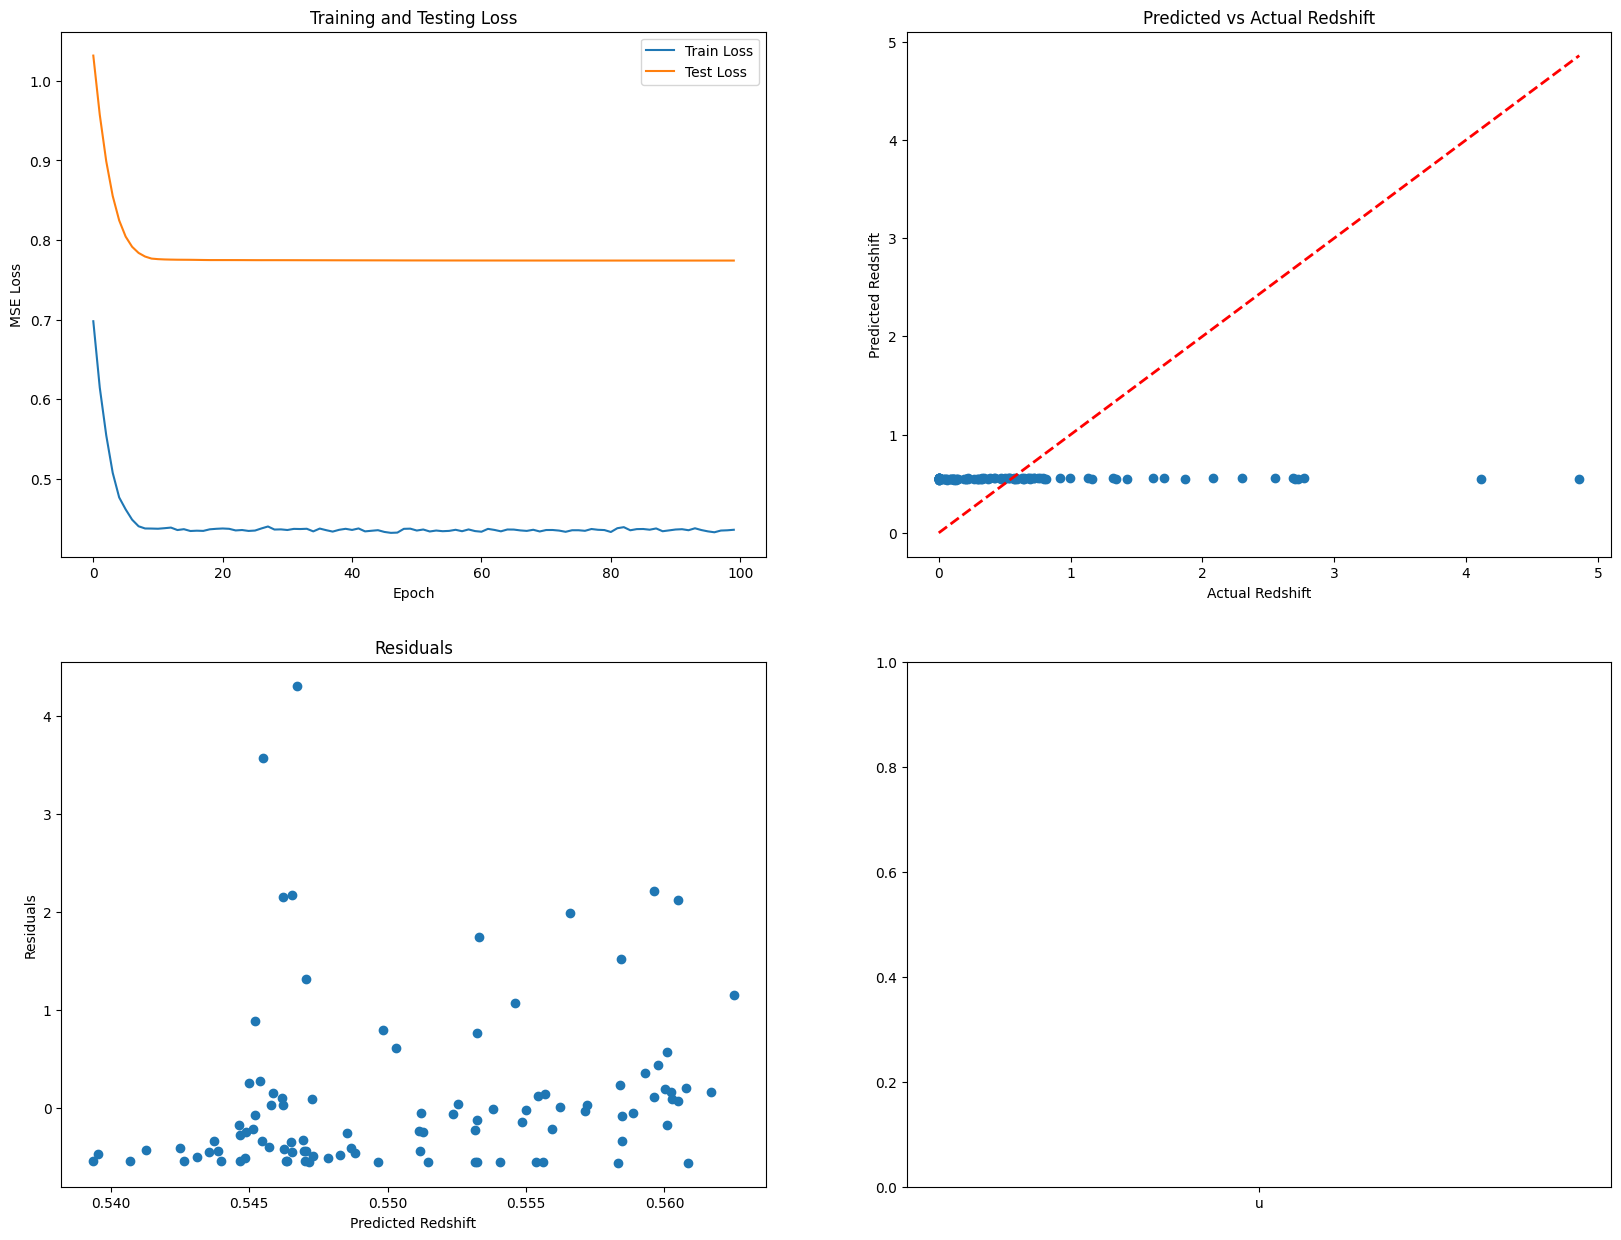

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load and preprocess the data
df = pd.read_csv('/content/star_classification.csv')
X = df[['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']]  # Using only the magnitude features
y = df['redshift']

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train = X_scaled[:200]
y_train = y[:200]
X_test = X_scaled[200:300]
y_test = y[200:300]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Define the quantum device
n_qubits = 10  # Increase qubits for more expressive power
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QCNN model
class QCNN(nn.Module):
    def __init__(self, n_qubits, n_layers, dropout_rate=0.2):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer to avoid overfitting
        self.fc = nn.Linear(n_qubits, 1)  # Output layer for redshift prediction

    def forward(self, x):
        x = torch.tensor([quantum_circuit(x_i, self.q_layers) for x_i in x], dtype=torch.float32)
        x = self.dropout(x)  # Apply dropout
        return self.fc(x).squeeze()  # Squeeze to remove extra dimension

# Initialize the model
model = QCNN(n_qubits=n_qubits, n_layers=4)  # Increased layers for more complexity

# Define loss function and optimizer
criterion = nn.MSELoss()  # Using MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
n_epochs = 100  # Increase epochs for better convergence
batch_size = 32

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / (len(X_train) // batch_size)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()

    test_losses.append(test_loss)

    # Step the scheduler after each epoch
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Final evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    mse = mean_squared_error(y_test, test_outputs)
    r2 = r2_score(y_test, test_outputs)
    print(f'Final Test MSE: {mse:.4f}, R2 Score: {r2:.4f}')

# Visualizations
plt.figure(figsize=(20, 15))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Predicted vs Actual
plt.subplot(2, 2, 2)
plt.scatter(y_test, test_outputs.detach().numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')

# Residuals
plt.subplot(2, 2, 3)
residuals = y_test - test_outputs.detach().numpy()
plt.scatter(test_outputs.detach().numpy(), residuals)
plt.title('Residuals')
plt.xlabel('Predicted Redshift')
plt.ylabel('Residuals')

# Feature Importance
plt.subplot(2, 2, 4)
feature_importance = np.abs(model.fc.weight.detach().numpy()).squeeze()
features = ['u', 'g', 'r', 'i', 'z', 'delta', 'alpha']
plt.bar(features, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()


In [ ]:
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.1):
    diff = np.abs(y_true - y_pred)
    correct_predictions = diff <= tolerance
    # Removed .cpu() as correct_predictions is already a NumPy array
    accuracy = np.sum(correct_predictions) / len(y_true) * 100
    return accuracy

# Calculate accuracy within tolerance of 0.1
accuracy = accuracy_within_tolerance(y_test.cpu().numpy(), test_outputs.detach().cpu().numpy(), tolerance=0.1) # Convert y_test to NumPy array
print(f'Accuracy (within 0.1 tolerance): {accuracy:.2f}%')